In [1]:
import os
import glob
import pandas as pd
import json
from collections import defaultdict
import xml.etree.ElementTree as et
from BeautifulSoup import BeautifulSoup as soup
import time
import matplotlib.pyplot as plt

In [2]:
#directory where data lives
data_dirs = glob.glob("/Users/bxie/Dropbox (MIT)/ai2_projects/*")

columns = ['id', 'project_name', 'user_name', 'num_screens']

NUM_PROJECTS = len(data_dirs) #Number of projects I'm parsing

"Number of Projects: " + str(NUM_PROJECTS)

'Number of Projects: 5228'

In [3]:
df = pd.DataFrame.from_csv("omit/ai2_data.csv")

In [4]:
#Functions to parse files

#Given project.properties file contents (as string),
#return dictionary with relevant info
def parse_properties(inp):
    lines = inp.split("\n") #split by line
    names = lines[0].split(".") #split by dot
    
    output = {"user_name": names[1][3:],
            "project_name": names[2].lower().strip()}

    return output

#Given scm file (as string), returns dictionary
#with keys as components and values as frequency of components
def parse_scm(inp):
    output = defaultdict(int)
    lines = inp.split("\n")
    json_str = lines[2] #json is all here; rest of lines don't matter
    j = json.loads(json_str)
    
    if "$Components" in j['Properties']:
        for component in j['Properties']['$Components']: #accessing list of components
            output['c_'+component['$Type']] += 1 #adding that component to dictionary
    return dict(output)

#Given bky file (as string), returns dictionary
#with keys as block types and values as frequency
def parse_bky(inp):
    output = defaultdict(int)
    b = soup(inp) #parsing xml w/ beautifulsoup
    blocks = b.findAll("block")
    for blk in blocks:
        output['b_'+blk["type"]]+=1
    print dict(output)
    return dict(output)

#Given list of frequency dictionaries, 
#merge dictionaries (summing similar keys) and returning it
def merge_dicts(dicts_list):
    if len(dicts_list>1):
        print 'MULTIPLE SCREENS!' #make sure this thing is working...
    result = {}
    keymap = {}
    for mydict in dicts_list:
        for (k,v) in mydict.items():
            if not keymap.has_key(k):
                keymap[k] = []
            keymap[k].append(v)
    for (k,v) in keymap.items():
        result[k] = sum(int(x) for x in keymap[k])
    return result    


In [235]:
#Feature extraction
#THIS TAKES TIME (~10 min)

df = pd.DataFrame(columns=columns)
t0 = time.time()

#Figure out how many missing files
num_missing_prop = 0
num_missing_scm = 0
num_missing_bky = 0

#Number of projects to process
# num_projects = 100

for my_dir in data_dirs:
# for x in range(0,num_projects):
#     my_dir = data_dirs[x]
    values = {} #dictionary of things to add to dataframe. key corresponds to column in df
    prop = {}
    scm = {}
    bky = {}
    
    values['id'] = str.split(my_dir, '/')[-1] #getting id of project from directory
    
    #properties
    dir_prop = glob.glob(my_dir+"/project.properties")
    if(len(dir_prop)>0):
        file_prop = open(dir_prop[0], 'r')
        prop = parse_properties(file_prop.read())
    else:
        num_missing_prop+=1
    
    #scm
    dir_scm = glob.glob(my_dir+"/*.scm")
    if(len(dir_scm)>0):
        scm_dicts = []
        #Getting dictionary of info from each screen
        for d in dir_scm:
            file_scm = open(d, 'r')    
            scm_dicts.append(parse_scm(file_scm.read()))
            
        #merging dictionaries of screen info
        if(len(dir_scm)>1):
            scm = merge_dicts(scm_dicts)
        else:
            scm = scm_dicts[0]
        
        values['num_screens'] = len(scm_dicts)
    else:
        num_missing_scm+=1

    #bky
    dir_bky = glob.glob(my_dir+"/*.bky") 
    if(len(dir_bky)>0):
        #equivalent logic as scm. too lazy to write a function...
        bky_dicts = []
        for d in dir_bky:
            file_bky = open(d, 'r')    
            bky_dicts.append(parse_bky(file_bky.read()))        
        
        if(len(dir_bky)>1):
            bky = merge_dicts(bky_dicts)
        else:
            bky = bky_dicts[0]
    else:
        num_missing_bky+=1
        
    stats = {'num_components':sum(scm.values()),
             'num_blocks':sum(bky.values())}
    values = dict(values.items() + stats.items() + prop.items() + scm.items() + bky.items())
    
    df = df.append(values, ignore_index=True)

t1 = time.time()
delta = t1 - t0

print "Execution Time: " + str(delta) + "sec (" + str(delta/60) + " min)" #around 8 min
print


Execution Time: 776.707015991sec (12.9451169332 min)



In [5]:
#Get projects where w/ >1000 blocks
df[['id','project_name','num_blocks', 'num_screens']][df.num_blocks>1000].sort(['num_blocks']).sort('num_blocks', ascending=False)

,id,project_name,num_blocks,num_screens
4418,6393920213745664,kingstore_preventivi_robi_checkpoint1,10059,15
2811,5696143266676736,ba_premcalc,5962,11
1807,5266910706925568,carlink__26,5825,11
894,4887794066391040,ports_v1_2_2_2,3336,9
1162,5004426469179392,bingoliveapp,3094,7
1663,5214147321004032,asteroids23,2955,1
2010,5354806619144192,kartentest_checkpoint2,2753,1
3857,6149761213136896,ktz_app,2655,5
2410,5528665328713728,termolinkv11,2397,5
4196,6301563509276672,passkeeper_v2_67,2377,1


In [241]:
print "Num of missing properties files: "+str(num_missing_prop)
print "Num of missing screen (scm) files: "+str(num_missing_scm)
print "Num of missing block (bky) files: "+str(num_missing_bky)

Num of missing properties files: 0
Num of missing screen (scm) files: 0
Num of missing block (bky) files: 23


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a674d50>]], dtype=object)

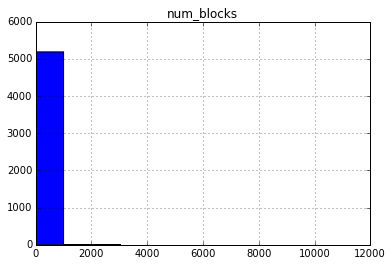

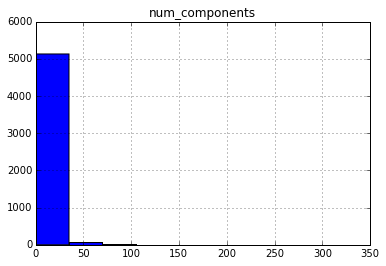

In [242]:
#Histograms
pd.DataFrame.hist(df, column="num_blocks")
pd.DataFrame.hist(df, column="num_components")

In [285]:
num_no_blks = len(df[df.num_blocks<2])
print "Number of projects w/ <2 blocks: " + str(num_no_blks) + " ("+str(num_no_blks*100/NUM_PROJECTS)+" % of projects)"

num_no_comp = len(df[df.num_components==0])
print "Number of projects w/ no components: " + str(num_no_comp) + " ("+str(num_no_comp*100/NUM_PROJECTS)+" % of projects)"

Number of projects w/ <2 blocks: 1094 (20 % of projects)
Number of projects w/ no components: 377 (7 % of projects)


In [244]:
#Dump data to csv file
df.to_csv("ai2_data.csv")

In [262]:
#Looking at # of projects that use variables
print len(df[df.b_global_declaration>0]) #/float(NUM_PROJECTS)
print
print len(df[df.b_lexical_variable_set>0]) #/float(NUM_PROJECTS)
print 
print len(df[df.b_lexical_variable_get>0]) #/float(NUM_PROJECTS)
print 


1514

1359

2219



In [265]:
#Looking at number of projects that use procedures
num_proc_def = len(df[df.b_procedures_defnoreturn>0]) + len(df[df.b_procedures_defreturn>0]) #projects that def procedures
num_proc_call = len(df[df.b_procedures_callreturn>0]) + len(df[df.b_procedures_callnoreturn>0]) #projects that call procedures

print num_proc_def 
print float(float(num_proc_def) / NUM_PROJECTS)
print
print num_proc_call
print float(float(num_proc_call) / NUM_PROJECTS)

845
0.161629686305

781
0.149387911247


In [7]:
#Get dataframe with 10 most populated columns (to identify most relevant features)
count = df.count()
count.sort(ascending=False) #series of column names, sorted by most populated columns
top_15 = count.keys()[:15] 
df_top = df[top_15]
df_top.head(10)

,id,project_name,user_name,num_screens,num_components,num_blocks,b_component_event,b_component_set_get,b_component_method,c_Button,b_text,b_lexical_variable_get,b_math_number,c_Label,c_HorizontalArrangement
0,4503600801775616,spaceinvaders,izzydafindon,1,4,48,7,19,1,1,NaN,1,8,NaN,1
1,4503601506418688,draw,7724,1,1,5,1,NaN,1,NaN,NaN,3,NaN,NaN,NaN
2,4503601917460480,flaggenerator18,scgs111064,1,5,19,6,6,NaN,NaN,NaN,NaN,NaN,1,1
3,4503602572820480,paintpot_random,808JRyan92,1,6,46,7,8,3,NaN,NaN,8,10,NaN,NaN
4,4503603176800256,pongkeyur,keyurpanchal1208,1,3,59,6,15,4,NaN,2,7,11,1,1
5,4503603769245696,image,h00227559,1,4,17,3,7,NaN,2,NaN,1,NaN,NaN,NaN
6,4503605315895296,app3t,yiher_chang,1,1,16,4,4,2,NaN,NaN,6,NaN,NaN,NaN
7,4503606143221760,zombielocatoe,northbest71,1,9,80,6,20,6,NaN,17,5,5,1,1
8,4503606162096128,helloworld1,20127681,1,2,3,1,1,NaN,1,1,NaN,NaN,NaN,NaN
9,4503607765368832,spaceship,Nuhauskis,1,3,48,7,19,1,NaN,NaN,1,8,NaN,1


In [10]:
# Finding tutorials by name
tutorials = {"hello_purr":"purr",
             "talk_to_me":"talk",
             "ball_bounce":"bounce",
             "digital_doodle:" : "doodle",
             "magic_8_ball": "magic",
             "paintpot" : "paint",
             "i_have_dream" : "dream",
             "pic_call": "piccall",
             "video_wall": "videowall|video_wall",
             "stockquotes": "stockquotes|stock_quotes",
             "mini_golf" : "minigolf|mini_golf",
             "space_invaders" : "spaceinvader|space_invader",
             "no_text":"notext|driving",
             "mash": "mash"}

tutorials_count = {}
total_tutorials = 0
total_working_tutorials = 0

for entry in tutorials:
    search_term = tutorials[entry]
    count_work = len(df_work[df_work.project_name.str.contains(search_term)])
    count_all = len(df[df.project_name.str.contains(search_term)])
    tutorials_count[entry] = count_work, count_all

    total_working_tutorials += count_work
    total_tutorials += count_all

print tutorials_count
print "total tutorials: " + str(total_tutorials) + "(" + str(float(total_tutorials)/ NUM_PROJECTS*100) +"%)"
print "total working tutorials: " + str(total_working_tutorials) + "(" + str(float(total_working_tutorials)/ NUM_PROJECTS*100) +"%)"

{'ball_bounce': (109, 112), 'paintpot': (162, 185), 'i_have_dream': (37, 42), 'digital_doodle:': (67, 71), 'video_wall': (3, 3), 'pic_call': (4, 4), 'magic_8_ball': (61, 68), 'mash': (122, 144), 'talk_to_me': (133, 152), 'space_invaders': (29, 30), 'mini_golf': (20, 21), 'stockquotes': (9, 9), 'hello_purr': (66, 82), 'no_text': (12, 14)}
total tutorials: 937(17.922723795%)
total working tutorials: 834(15.9525631217%)


In [178]:
#Extract relevant features to clasify tutorials

relevant_features = {}

# Given a search term, takes projects that contain the search term in project_name,
# returns dataframe of features that exist in at least threshold (float, [0,1]) of the projects
def feature_finder(search_term):
    #Ignoring meta data
    omit = ['id', 'user_name', 'project_name'] #num_blocks, num_components, num_screens may go here
    tutorial = df[df.project_name.str.contains(search_term)]
    tutorial = tutorial.dropna(axis=1, how="all")
    num_tutorials = len(tutorial)
    threshold = 0.4
    
    count = tutorial.count()
    count = dict(count)
    
    #finds features that exist in thershold of the projects
    features = [ x[0] for x in count.items() if x[1]>(num_tutorials*threshold) ]
    
    #removing meta data
    for val in omit:
        features.remove(val)
    
    # TODO: DON'T USE MEDIAN HERE. PASS IN RANGE BETWEEN QUARTILE 1-3???
    return df[features]

#Given iterable where key is feature and value is freq,
#return filtered dataframe where feature == value for all in features
def find_projects(features):
    q = ""
    for f in features.keys():
        count = features[f]
        q = q+"(" + f + ">" + str(count-1) + " or " + f + "<" + str(count+1)+") and "
    q = q[:-5] #removing trailing " and "
    print q
    return df.query(q)

#DOESN'T QUITE WORK. JUST USE SCIKIT LEARN CLASSIFICATION!
def find_projects(features):
    q = ""
    for f in features.keys():
        count = int(features[f])
        q = q+"(" + f + ">" + str(count-1) + " or " + f + "<" + str(count+1)+") and "
    q = q[:-5] #removing trailing " and "
    print q
    return df.query(q)

In [179]:
all_features = [] #All features found in at least 50% of a tutorial
for tut in tutorials:
    search_term = tutorials[tut]
    features = feature_finder(search_term)
    for col in features.columns:
        if col not in all_features:
            all_features.append(col)
#     relevant_features[tut] = features.median()

#Find all hellopurrs given features. DOESN'T WORK!!!
# purr_features = relevant_features["hello_purr"]
# df_f = find_projects(purr_features)

purr_features = df[all_features].median()
find_projects(purr_features)

(num_blocks>12 or num_blocks<14) and (c_Canvas>0 or c_Canvas<2) and (b_component_event>2 or b_component_event<4) and (num_components>3 or num_components<5) and (num_screens>0 or num_screens<2) and (b_component_set_get>5 or b_component_set_get<7) and (b_component_method>1 or b_component_method<3) and (b_lexical_variable_get>4 or b_lexical_variable_get<6) and (c_Button>0 or c_Button<2) and (c_PhoneCall>0 or c_PhoneCall<2) and (c_PhoneNumberPicker>0 or c_PhoneNumberPicker<2) and (b_text>4 or b_text<6) and (c_VerticalArrangement>0 or c_VerticalArrangement<2) and (c_Label>0 or c_Label<2) and (b_lists_create_with>1 or b_lists_create_with<3) and (b_lists_pick_random_item>0 or b_lists_pick_random_item<2) and (c_Sound>0 or c_Sound<2) and (c_Clock>0 or c_Clock<2) and (b_math_division>1 or b_math_division<3) and (c_HorizontalArrangement>1 or c_HorizontalArrangement<3) and (b_math_subtract>1 or b_math_subtract<3) and (b_logic_false>3 or b_logic_false<5) and (b_math_add>1 or b_math_add<3) and (b_lo

ValueError: too many inputs

In [163]:
df[df.id==6409158715768832][['num_blocks', 'num_components']]

,num_blocks,num_components
4453,30,5


In [11]:
#Removing projects that are "certainly" incomplete
df_work = df_top[df_top.num_blocks>=2][df_top.num_components>0]

In [12]:
#Looking at projects that "might" work (removing "certainly incomplete" projects)
df_work.describe()

,id,num_screens,num_components,num_blocks,b_component_event,b_component_set_get,b_component_method,c_Button,b_text,b_lexical_variable_get,b_math_number,c_Label,c_HorizontalArrangement
count,4.121000e+03,4121.000000,4121.000000,4121.000000,4049.000000,3301.000000,2989.000000,2345.000000,2472.000000,2214.000000,2065.000000,1783.000000,1762.000000
mean,1.139137e+15,1.522931,7.136617,76.515652,5.637935,19.342321,6.860154,2.015778,17.203479,13.742547,15.133656,2.718452,2.982406
std,6.450910e+14,1.828449,12.903225,284.280577,10.553848,75.574834,28.099076,3.248156,67.933737,37.678230,45.995213,5.982797,6.356638
min,4.503601e+15,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.065833e+15,1.000000,3.000000,8.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3.000000,2.000000,1.000000,1.000000
50%,5.615349e+15,1.000000,4.000000,22.000000,3.000000,6.000000,2.000000,1.000000,5.000000,5.000000,5.000000,1.000000,2.000000
75%,6.167554e+15,1.000000,7.000000,55.000000,6.000000,15.000000,5.000000,2.000000,12.000000,10.000000,12.000000,2.000000,3.000000
max,6.755039e+15,31.000000,350.000000,10059.000000,303.000000,2637.000000,862.000000,61.000000,1605.000000,637.000000,1209.000000,122.000000,140.000000


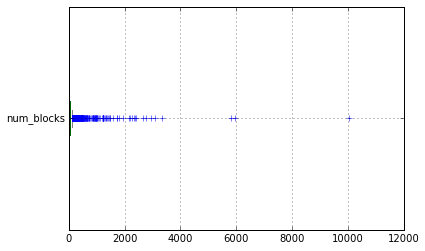

In [281]:
#Trying to make histogram...outliers make it look silly
# pd.DataFrame.boxplot(df, column='num_blocks')
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df['num_blocks'].plot(kind='box', vert=False, color=color, sym='')

In [306]:
#Trying to get breakdown of tutorials for pie chart (or equiv)...kinda works, kinda doesnt. what ev.
df_tut = pd.DataFrame(columns=['name', 'might_work', 'total'])
for v in tutorials_count:
    may_work = tutorials_count[v][0]
    total = tutorials_count[v][1]
    temp = {'name': v,
            'might_work': may_work,
            'total': total}
    df_tut = df_tut.append(temp, ignore_index=True)

In [307]:
df_tut

,name,might_work,total
0,ball_bounce,109,112
1,paintpot,162,185
2,i_have_dream,37,42
3,digital_doodle:,67,71
4,video_wall,3,3
5,pic_call,4,4
6,magic_8_ball,61,68
7,mash,122,144
8,talk_to_me,133,152
9,space_invaders,29,30


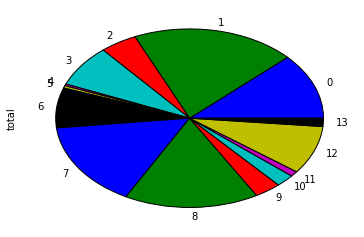

In [335]:
df_tut['total'].plot(kind='pie', stacked=True)

In [332]:
total_tutorials = {}


df_tut2 = pd.DataFrame.from_dict(tutorials_count)

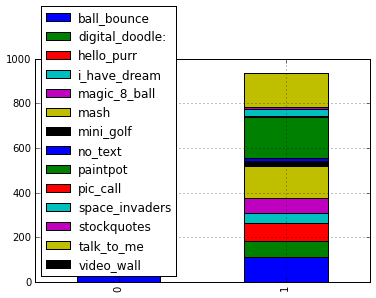

In [320]:
df_tut2.plot(kind='bar', stacked=True)

In [339]:
df_work[df.num_screens>20]

,id,project_name,user_name,num_screens,num_components,num_blocks,b_component_event,b_component_set_get,b_component_method,c_Button
2304,5480573427515392,robot_to_auto_zone,adeleon3333,24,86,160,53,NaN,NaN,23
3576,6031732437417984,ali_mobiles_3g,fa51525152,28,81,90,29,3,3,NaN
3649,6061183887998976,ivideo1,yiz0604,31,89,991,99,395,6,NaN
4741,6533209685753856,ivideo2,yiz0604,31,89,991,99,395,6,NaN


In [349]:
#Looking at 10 most populated columns
print df_top.count()
print
print df_top.count()/NUM_PROJECTS

id                         5228
project_name               5228
user_name                  5228
num_screens                5228
num_components             5228
num_blocks                 5228
b_component_event          4107
b_component_set_get        3313
b_component_method         2993
c_Button                   2696
b_text                     2477
b_lexical_variable_get     2219
b_math_number              2072
c_Label                    1947
c_HorizontalArrangement    1901
dtype: int64

id                         1.000000
project_name               1.000000
user_name                  1.000000
num_screens                1.000000
num_components             1.000000
num_blocks                 1.000000
b_component_event          0.785578
b_component_set_get        0.633703
b_component_method         0.572494
c_Button                   0.515685
b_text                     0.473795
b_lexical_variable_get     0.424445
b_math_number              0.396327
c_Label                    0.372418
c_